# LLM Training Data Augmentation - Classification of Kaggle Disaster Data

The goal of this notebook is to prepare the data for augmentation by an LLM and classification by two models:

1. Logistic regression
2. Single hidden-layer neural network

## Data

The data used in this project comes from the kaggle *Natural Language Processing with Disaster Tweets* competition at:  

https://www.kaggle.com/competitions/nlp-getting-started/data

This data consists of two files:
+ *train.csv* - 7613 labled tweets
+ *test.csv* - 3236 unlabled tweets

Because the *test.csv* labels are not available, the *train.csv* file was split into the following two files:

+ train_model.csv - data used to train model, 6090 labeled tweets
+ train_test.csv - held out and not used to train model, used as *pseudo-test* data, 1523 labeled tweets (~20% of the original training sample)

## Non-Transformer Models

Two types of models are created and compared:

1. Logistic Regression - This serves as the baseline
2. Single-Hidden layer neural network with 1000 nodes in the hidden layer

## LLM

ChatGPT 3.5 turbo will be used to augment the data used to train the models.

## Encodings

The Twitter GloVe embedding will be used to vectorize the input text.  These embeddings were downloaded from:

https://nlp.stanford.edu/data/glove.twitter.27B.zip


# Preprocessing

## Manual inspection of train.csv

The following issues observered in the data are listed below.  They are numbered to indicate the order in which they were processed.  For example, spillover lines were fixed first, then URLs, etc.  This order is important because removing things like punctuation too early would make things like identifying user names or hashtags in a tweet impossible or make URLs invalid.

### 1. Spillover lines

The first issue we see with this data is that while most of the samples are on there own line, some spill over to adjacent lines. Here are few examples:

>`61,ablaze,,"on the outside you're ablaze and alive`  
>`but you're dead inside",0`  
>`74,ablaze,India,"Man wife get six years jail for setting ablaze niece`  
>`http://t.co/eV1ahOUCZA",1`  
>`86,ablaze,Inang Pamantasan,"Progressive greetings!`  
>  
>`In about a month students would have set their pens ablaze in The Torch Publications'... http://t.co/9FxPiXQuJt",0`  
>`117,accident,,"mom: 'we didn't get home as fast as we wished'`  
>`me: 'why is that?'`  
>`mom: 'there was an accident and some truck spilt mayonnaise all over ??????",0`

The custom function `fix_spillover_lines` was written to fix these lines. Its code is available in the projtools module.

### 2. Text-Target Duplicates

### 3. Cross-Target Duplicats

### 4. Normalizing URLs

Some tweet contain one or more URLs.  I assume that the content of a ULR does not contain any useful, but since a `<url>` token exists in the twitter gloVe embeddings, URLS will be replaced by this token.  

Although the actual URL may not contain much useful information, the count of URLs occuring in a tweet may be a useful feature and are counted before they are normalized.  About 90% of the URLs in the training data are of the form `http://t.co/<10 digit hash>`. For example: `http://t.co/9FxPiXQuJt`.  In about 10% of cases, these URLs start with `https:\\`.

The `replace_urls` function replaces each URL by the string "<url>" for the reasons stated above.

<s>#### 2.1 Counting URLs in each tweet</s>

<s>The custom function `make_url_counts` is used to create a `url_count` feature/column.  This needs to be called before calling `replace_urls`.</s>

### 5. Process Twitter-specifc characters

Because the `@` and `#` characters have special meaning in tweets, they need to be processed before removing other punctuation.  When a `@<username>` is seen in a tweet, it is a reference to a user whose name is `username`.  When a `#<hashname>` is seen in a tweet, it specifies a hashtag which is a reference to all tweet tweets that use the `hashname` hashtag.  In processing these characters, `@<username>` is converted to `<user> username` and `#<hashname>` is converted to `<hashtag> hashname`.  These replacement tokens were selected because they also have mappings in the embeddings file described in the **Normalizing URLs** section.

### 6. Expanding Contractions

Contraction fragments are included as vectorized tokens in the twitter gloVe embeddings which means that we don't need to expand these manually.  The spaCy tokenizer will separate the first word from the contraction fragments: e.g "you're" will be tokenized into `["you", "'re"]`.  Because the embeddings file has a listing for the contraction fragment token `'re` (as well as other contraction fragments such as 'm, 's, 'll, etc.), we don't need to convert these to their actual word forms (e.g. "am", "is", "will", etc.) before vectorizing.

### 7. Remove digits

The function `replace_numbers` is run to replace sets of consecutive digits digits with the token `<number>`.  As with the other token replacements, this one also was chosen because it has a mapping in the embeddings file.

### 8. Remove stop words

### 9. Lemmatization

### 8. Remove remaining punctuation and make lower case

The custom function `replace_with_space` is run to remove any remaining punctuation.



In [1]:
import numpy as np
import string as st
import matplotlib as mp
import matplotlib.pyplot as plt

# To get around the "UnicodeDecodeError: 'charmap' codec can't decode byte ..." error,
# need specify encoding when reading this data in as described in the solution I upvoted here:
# https://stackoverflow.com/questions/9233027/unicodedecodeerror-charmap-codec-cant-decode-byte-x-in-position-y-character
# with open("./data/train.csv", encoding="utf8") as f:  # works, but setting errors removes unneeded chars
with open("./data/train.csv", encoding="utf8", errors='ignore') as f_train:
    content_train = f_train.readlines()

with open("./data/test.csv", encoding="utf8", errors='ignore') as f_test:
    content_test = f_test.readlines()

print(len(content_train), len(content_test))  # 8562, 3700  BEFORE applying any fixes

8562 3700


In [2]:
# print some examples of manually identified spillover lines
with open("./debug/train_debug_spillover_chunk.txt", encoding="utf8", errors='ignore') as f:
    content_train_debug = f.readlines()

for i in [0, 42, 43, 53, 54, 64, 65, 66]:
    print(content_train_debug[i].strip())

id,keyword,location,text,target
61,ablaze,,"on the outside you're ablaze and alive
but you're dead inside",0
74,ablaze,India,"Man wife get six years jail for setting ablaze niece
http://t.co/eV1ahOUCZA",1
86,ablaze,Inang Pamantasan,"Progressive greetings!

In about a month students would have set their pens ablaze in The Torch Publications'... http://t.co/9FxPiXQuJt",0


In [3]:
import projtools as pt
# test the fix for the spillover lines on the training data
fixed_train_debug = pt.fix_spillover_lines(content_train_debug)

# for i, line in enumerate(fixed_list):
#     print(i, line)

# check that good lines are still good and spillover lines (*) are fixed
#id = header 32  25 *61 *74 *86 *117 119 120
for j in [0, 22, 36, 42, 52, 62, 81, 83, 84]:
    print(fixed_train_debug[j])  # spillover lines are now consolidated to a single line

fix_spillover_lines fixed 10 lines...
id,keyword,location,text,target
32,,,London is cool ;),0
53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0
61,ablaze,,"on the outside you're ablaze and alive but you're dead inside",0
74,ablaze,India,"Man wife get six years jail for setting ablaze niece http://t.co/eV1ahOUCZA",1
86,ablaze,Inang Pamantasan,"Progressive greetings!  In about a month students would have set their pens ablaze in The Torch Publications'... http://t.co/9FxPiXQuJt",0
117,accident,,"mom: 'we didn't get home as fast as we wished' me: 'why is that?' mom: 'there was an accident and some truck spilt mayonnaise all over ??????",0
119,accident,,Can wait to see how pissed Donnie is when I tell him I was in ANOTHER accident??,0
120,accident,"Arlington, TX",#TruckCrash Overturns On #FortWorth Interstate http://t.co/Rs22LJ4qFp Click here if you've been in a crash&gt;http://t.co/Ld0unIYw4k,1


In [4]:
# fix the spillover lines in the train and test data, then write out fixed data
# fixed_train = pt.fix_spillover_lines(content_train)
# with open(file='./data/train_clean_v01.csv', mode='w', encoding="utf8", errors='ignore') as f_train_out:
#     for line in fixed_train:
#         f_train_out.write(line)
#         f_train_out.write('\n')

# fixed_test = pt.fix_spillover_lines(content_test)
# with open(file='./data/test_clean_v01.csv', mode='w', encoding="utf8", errors='ignore') as f_test_out:
#     for line in fixed_test:
#         f_test_out.write(line)
#         f_test_out.write('\n')
#
# OUTPUT:
# fix_spillover_lines fixed 1385 line...
# fix_spillover_lines fixed 648 line...

## Spillover line counts

The `fix_spillover_lines` prints the number of lines it fixed before returning a list of fixed lines. Both files has roughly similar portions of their data that needed fixing:
+ train.csv - 1385 lines (1385 / 8562 = 16%) were fixed/consolidated
+ test.csv - 648 lines (648 / 3700 = 17.5%) were fixed/consolidated

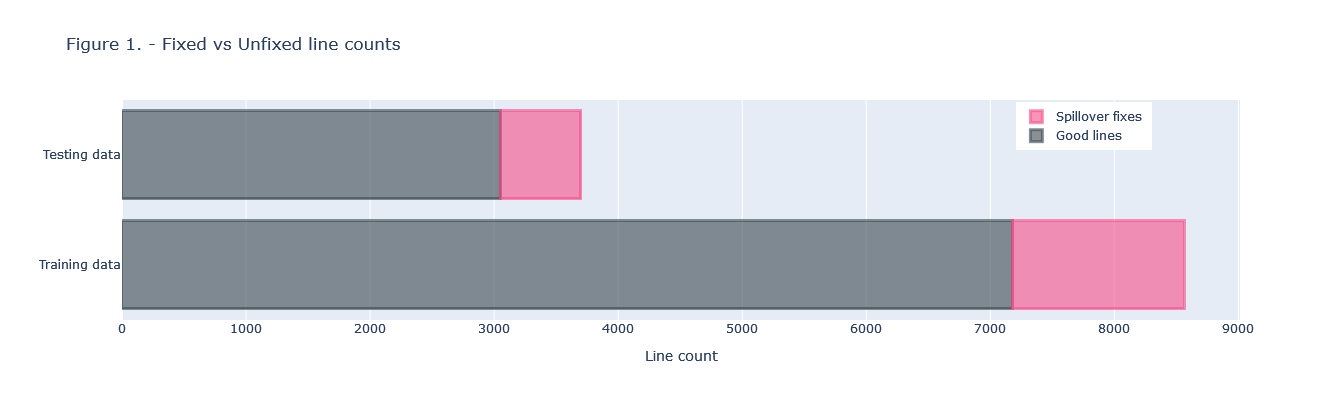

In [5]:
import plotly.graph_objects as go

fig_fix_counts = go.Figure()
fig_fix_counts.add_trace(
    go.Bar(
        y = ['Training data', 'Testing data'],
        x = [8562 - 1385, 3700 - 648],
        name = 'Good lines',
        orientation = 'h',
        marker=dict(
            color='rgba(58, 71, 80, 0.6)',
            line=dict(color='rgba(58, 71, 80, 0.6)', width=3)
        )
    )
)
fig_fix_counts.add_trace(
    go.Bar(
        y = ['Training data', 'Testing data'],
        x = [1385, 648],
        name = 'Spillover fixes',
        orientation = 'h',
        marker=dict(
            color='rgba(246, 78, 139, 0.6)',
            line=dict(color='rgba(246, 78, 139, 0.6)', width=3)
        )
    )
)

fig_fix_counts.update_layout(barmode='stack')
fig_fix_counts.update_layout(title='Figure 1. - Fixed vs Unfixed line counts',
                             xaxis_title='Line count',
                             yaxis_title='',
                             legend=dict(yanchor="top",
                                         y=0.99,
                                         xanchor="left",
                                         x=0.80),
                  autosize=False,
                  width=900,
                  height=400)
fig_fix_counts.show()

## Missing tweets or targets?

In [6]:
import pandas as pd

df_train_v01 = pd.read_csv("./data/train_clean_v01.csv", encoding="utf8")
df_test_v01 = pd.read_csv("./data/test_clean_v01.csv", encoding="utf8")

print(pd.isnull(df_train_v01["text"]).sum())    # no missing tweets, confirmed by histograms and min len()
print(pd.isnull(df_train_v01["target"]).sum())  # no missing targets

0
0


In [7]:
%%cmd
dir

Microsoft Windows [Version 10.0.19045.4170]
(c) Microsoft Corporation. All rights reserved.

(llmamd) D:\llmamd>dir
 Volume in drive D is 2Tb_R1_SSD
 Volume Serial Number is C226-2BFD

 Directory of D:\llmamd

03/26/2024  02:57 PM    <DIR>          .
03/26/2024  02:57 PM    <DIR>          ..
02/16/2024  02:34 PM               321 .gitignore
03/01/2024  02:28 PM    <DIR>          .ipynb_checkpoints
03/23/2024  07:44 PM            30,167 chatgpt_sandbox.ipynb
03/25/2024  07:48 PM    <DIR>          data
02/13/2024  12:34 PM    <DIR>          debug
03/19/2024  07:27 PM    <DIR>          docs
02/23/2024  02:36 PM    <DIR>          eda
03/20/2024  06:35 PM    <DIR>          embeddings_models
02/11/2024  06:11 PM            26,391 hf_text_gen.ipynb
03/07/2024  09:04 AM            23,161 labeling_errors.ipynb
03/03/2024  11:14 PM             3,437 llmamd_requirements.txt
03/26/2024  02:57 PM         4,529,404 preproc_disaster.ipynb
03/24/2024  04:56 PM            21,268 projtools.py
02/01/2024

## Duplicated tweets

### text-target duplicates

Tweets that have identical `(text, target)` tuples are considered duplicates in this project because the other 3 fields (`id`, `location`, `keyword`) are not being used in the analysis.  We start by removing these *text-target* duplicates.

### cross-target duplicates

In addition to *text-target* duplicates, a small number of tweets with the same `text` string, but with a different target value also appear in the data.  These *cross-target* duplicates should not exist because they refer to the same tweet text, but have a different target.  These kinds of duplicates are removed after the *text-target* duplicates are removed before generating augmented samples.

In [8]:
# check for any duplicate id values
df_duplicated_ids_train = df_train_v01[df_train_v01.duplicated(['id'], keep=False)]  # keep=False=show all duplicated rows
df_duplicated_ids_train.shape  # (0, 5) so none

(0, 5)

In [9]:
# keep just the first instance of text-target duplicates and filter out the rest
# keep='first': Marks duplicates as True except for the first occurrence
df_text_target_dupes_train = df_train_v01[df_train_v01.duplicated(['text', 'target'], keep='first')]
print(f"{df_train_v01.shape[0]} rows BEFORE text-target duplicates removed |",
      f"{df_text_target_dupes_train.shape[0]} text-target duplicate rows to be removed")  # 7613 rows before duplicates removal, 92 rows to remove

7613 rows BEFORE text-target duplicates removed | 92 text-target duplicate rows to be removed


In [10]:
df_text_target_dupes_train.sort_values(['text', 'id'])

id         keyword                    location  \
4299  6105        hellfire  ?????? ??? ?????? ????????   
6366  9098  suicide%20bomb                     Nigeria   
6373  9107  suicide%20bomb                     Nigeria   
6377  9113  suicide%20bomb                     Nigeria   
6378  9114  suicide%20bomb                     Nigeria   
...    ...             ...                         ...   
4834  6881   mass%20murder                   Anonymous   
4631  6582          injury                         NaN   
3461  4952        exploded                         NaN   
6103  8714         sinking                         NaN   
6123  8739         sinking                          MA   

                                                   text  target  
4299  #Allah describes piling up #wealth thinking it...       0  
6366  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1  
6373  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1  
6377  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1  
6378  #Bestnaijamade: 16yr old PKK suicide bomber wh...       1  
...                                                 ...     ...  
4834  http://t.co/c1H7JECFrV @RoyalCarribean do your...       1  
4631  incident with injury:I-495  inner loop Exit 31...       1  
3461  that exploded &amp; brought about the beginnin...       0  
6103  that horrible sinking feeling when youÛªve be...       0  
6123  that horrible sinking feeling when youÛªve be...       1  

[92 rows x 5 columns]

In [11]:
# remove the text-target dupes - keep everything that is not in the dupes dataframe
df_train_v02 = df_train_v01.loc[~df_train_v01['id'].isin(df_text_target_dupes_train['id']), :]
expected_v02_train_rows = df_train_v01.shape[0] - df_text_target_dupes_train.shape[0]
print(f"{expected_v02_train_rows} should be the number of rows after text-target dupes are removed")
print(f"{df_train_v02.shape[0]} rows AFTER text-target dupes removed")  # 7613 - 92 = 7521 rows after removal, check
# write the v02 training data to a file, commented out because only need to do once unless there are changes
# df_train_v02.to_csv(path_or_buf="./data/train_clean_v02.csv", index=False, encoding='utf-8')

7521 should be the number of rows after text-target dupes are removed
7521 rows AFTER text-target dupes removed


In [12]:
# remove ALL cross-target duplicates because we don't know which are true and which are not
# keep=False: Marks all duplicates as True
df_cross_target_dupes_train = df_train_v02[df_train_v02.duplicated(['text'], keep=False)]
df_cross_target_dupes_train = df_cross_target_dupes_train.sort_values(['text', 'target'])
print(df_cross_target_dupes_train.shape)
df_cross_target_dupes_train

(36, 5)


id              keyword                  location  \
4290  6094             hellfire  Jubail IC, Saudi Arabia.   
4312  6123             hellfire        ?????? ???? ??????   
4244  6031            hazardous          New Delhi, Delhi   
4221  5996            hazardous                       NaN   
2832  4076            displaced  Pedophile hunting ground   
2830  4068            displaced  Pedophile hunting ground   
4618  6566               injury                       NaN   
4597  6537               injury                       NaN   
4235  6017            hazardous                       NaN   
4232  6012            hazardous                       NaN   
3240  4656             engulfed                       NaN   
3243  4659             engulfed                   Kuwait    
4285  6088             hellfire                       NaN   
4305  6112             hellfire                       NaN   
4306  6113             hellfire                       NaN   
4320  6134             hellfire                 Riyadh ')   
1214  1752  buildings%20burning            Epic City, BB.   
1365  1968  burning%20buildings            Epic City, BB.   
6614  9470            terrorism      Jeddah_Saudi Arabia.   
6616  9472            terrorism                    Riyadh   
1331  1922  burning%20buildings    Mackay, QLD, Australia   
1197  1723  buildings%20burning    Mackay, QLD, Australia   
4379  6220             hijacker                 worldwide   
4381  6223             hijacker                 worldwide   
4284  6087             hellfire                       NaN   
4292  6097             hellfire                       NaN   
624    898         bioterrorism                       NaN   
610    881         bioterrorism                       NaN   
4013  5699               floods                       NaN   
3985  5662               floods                       NaN   
1349  1950  burning%20buildings                    dallas   
1221  1760  buildings%20burning                    dallas   
6094  8702              sinking                       NaN   
6091  8698              sinking  Every Where in the World   
5641  8044             refugees                       NaN   
5620  8018             refugees                       NaN   

                                                   text  target  
4290  #Allah describes piling up #wealth thinking it...       0  
4312  #Allah describes piling up #wealth thinking it...       1  
4244  #foodscare #offers2go #NestleIndia slips into ...       0  
4221  #foodscare #offers2go #NestleIndia slips into ...       1  
2832  .POTUS #StrategicPatience is a strategy for #G...       0  
2830  .POTUS #StrategicPatience is a strategy for #G...       1  
4618  CLEARED:incident with injury:I-495  inner loop...       0  
4597  CLEARED:incident with injury:I-495  inner loop...       1  
4235  Caution: breathing may be hazardous to your he...       0  
4232  Caution: breathing may be hazardous to your he...       1  
3240  He came to a land which was engulfed in tribal...       0  
3243  He came to a land which was engulfed in tribal...       1  
4285  Hellfire is surrounded by desires so be carefu...       0  
4305  Hellfire is surrounded by desires so be carefu...       1  
4306  Hellfire! We donÛªt even want to think about ...       0  
4320  Hellfire! We donÛªt even want to think about ...       1  
1214  I Pledge Allegiance To The P.O.P.E. And The Bu...       0  
1365  I Pledge Allegiance To The P.O.P.E. And The Bu...       1  
6614  In #islam saving a person is equal in reward t...       0  
6616  In #islam saving a person is equal in reward t...       1  
1331  Mmmmmm I'm burning.... I'm burning buildings I...       0  
1197  Mmmmmm I'm burning.... I'm burning buildings I...       1  
4379  RT NotExplained: The only known image of infam...       0  
4381  RT NotExplained: The only known image of infam...       1  
4284  The Prophet (peace be upon him) said 'Save you...       0  
4292  The Prophet (peace be upon h

In [13]:
# remove the cross-target dupes
print(f"{df_train_v02.shape[0]} rows BEFORE cross-target duplicates removed |",
      f"{df_cross_target_dupes_train.shape[0]} duplicate rows to be removed")  # 7521 rows before duplicates removal, 36 rows to remove
df_train_v03 = df_train_v02[~df_train_v02.duplicated(['text'], keep=False)]
expected_v03_train_rows = df_train_v02.shape[0] - df_cross_target_dupes_train.shape[0]
print(f"{expected_v03_train_rows} should be the number of rows after cross-target dupes are removed")
print(f"{df_train_v03.shape[0]} rows AFTER text-target dupes removed")  # 7521 - 36 = 7485 rows after removal, check
# write the v03 training data to a file, commented out because only need to do once unless there are changes
# df_train_v03.to_csv(path_or_buf="./data/train_clean_v03.csv", index=False, encoding='utf-8')

7521 rows BEFORE cross-target duplicates removed | 36 duplicate rows to be removed
7485 should be the number of rows after cross-target dupes are removed
7485 rows AFTER text-target dupes removed


In [14]:
# check for duplicate tweets in test set
duplicated_rows_test = df_test_v01[df_test_v01.duplicated(['text'], keep=False)].sort_values(['text'])
print(duplicated_rows_test.shape)
duplicated_rows_test  # looks like there are 39, but need to live with these.

(39, 4)


id              keyword                  location  \
128     408           apocalypse                       NaN   
3114  10312               weapon                       NaN   
2741   9129       suicide%20bomb                   Nigeria   
2744   9138       suicide%20bomb                   Nigeria   
600    1947  burning%20buildings                  US of Eh   
540    1765  buildings%20burning                  US of Eh   
1233   4053            displaced  Pedophile hunting ground   
1234   4056            displaced  Pedophile hunting ground   
1544   5158                fatal                    Baroda   
1537   5123                fatal                   Gurgaon   
1536   5121                fatal                       NaN   
47      152           aftershock               Switzerland   
53      177           aftershock               Switzerland   
2043   6868        mass%20murder    Somewhere on the Earth   
510    1668              bombing    Somewhere on the Earth   
1044   3427               derail    w/ @_ridabot, probably   
1051   3449               derail    w/ @_ridabot, probably   
1301   4285             drowning                 Liverpool   
1302   4286             drowning                       NaN   
607    1982         bush%20fires                       NaN   
612    1998         bush%20fires                       NaN   
2904   9623         thunderstorm             United States   
2910   9633         thunderstorm  Florence, South Carolina   
1217   3999             disaster                    Ottawa   
2153   7217   natural%20disaster                    Ottawa   
2740   9127       suicide%20bomb                       NaN   
2731   9092       suicide%20bomb                       NaN   
1072   3546           derailment                       NaN   
1066   3515           derailment                       NaN   
1892   6377             hostages           Rocky Mountains   
1893   6378             hostages           Rocky Mountains   
286     924         bioterrorism                       NaN   
285     922         bioterrorism                       NaN   
3235  10758             wreckage                     India   
3230  10738             wreckage                     India   
2733   9105       suicide%20bomb                       NaN   
2734   9108       suicide%20bomb                       NaN   
1489   4949             exploded                       NaN   
1481   4930             exploded              Ittihad .f.c   

                                                   text  
128   #AskConnor there's a zombie apocalypse. the it...  
3114  #AskConnor there's a zombie apocalypse. the it...  
2741  #Bestnaijamade: 16yr old PKK suicide bomber wh...  
2744  #Bestnaijamade: 16yr old PKK suicide bomber wh...  
600   .@denisleary Not sure how these folks rush int...  
540   .@denisleary Not sure how these folks rush int...  
1233  .POTUS #StrategicPatience is a strategy for #G...  
1234  .POTUS #StrategicPatience is a strategy for #G...  
1544  11-Year-Old Boy Charged With Manslaughter of T...  
1537  11-Year-Old Boy Charged With Manslaughter of T...  
1536  11-Year-Old Boy Charged With Manslaughter of T...  
47    320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...  
53    320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...  
2043  70 yrs since the atomic bombing of Hiroshima.....  
510   70 yrs since the atomic bombing of Hiroshima.....  
1044  @PumpkinMari_Bot lemme just derail this real q...  
1051  @PumpkinMari_Bot lemme just derail this real q...  
1301  Boy saves autistic brother from drowning: A ni...  
1302  Boy saves autistic brother from drowning: A ni...  
607   Bushfire causes first victim in Albania ::  Th...  
612   Bushfire causes first victim in Albania ::  Th...  
2904  GSP issues STRONG THUNDERSTORM WILL IMPACT POR...  
2910  GSP issues STRONG THUNDERSTORM WILL IMPACT POR...  
1217  IRIN Asia | Red tape tangles Nepal reconstruct...  
2153  IRIN Asia | Red tape tangles Nepal reconstruct...  
2740  International 

### Replace URLs with token

In [15]:
%pwd

'D:\\llmamd'

In [16]:
df_train_v03 = pd.read_csv("./data/train_clean_v03.csv", encoding="utf8")
df_test_v01 = pd.read_csv("./data/test_clean_v01.csv", encoding="utf8")
print(df_train_v03.shape, df_test_v01.shape)

(7485, 5) (3263, 4)


In [17]:
train_v04_id = df_train_v03['id'].tolist()
train_v04_keyword = df_train_v03['keyword'].tolist()
train_v04_location = df_train_v03['location'].tolist()
train_v04_text = df_train_v03['text'].tolist()
train_v04_target = df_train_v03['target'].tolist()

train_v04_text_urls_fixed = pt.replace_urls(train_v04_text)  # only changing this column
df_train_v04 = pd.DataFrame({'id': train_v04_id,
                             'keyword': train_v04_keyword,
                             'location': train_v04_location,
                             'text': train_v04_text_urls_fixed,
                             'target': train_v04_target})

df_train_v04.loc[32:50, :]

id keyword                       location  \
32  49  ablaze  Est. September 2012 - Bristol   
33  50  ablaze                         AFRICA   
34  52  ablaze               Philadelphia, PA   
35  53  ablaze                     London, UK   
36  54  ablaze                       Pretoria   
37  55  ablaze                   World Wide!!   
38  56  ablaze                            NaN   
39  57  ablaze                 Paranaque City   
40  59  ablaze                 Live On Webcam   
41  61  ablaze                            NaN   
42  62  ablaze                      milky way   
43  63  ablaze                            NaN   
44  64  ablaze                            NaN   
45  65  ablaze                            NaN   
46  66  ablaze      GREENSBORO,NORTH CAROLINA   
47  67  ablaze                            NaN   
48  71  ablaze                       England.   
49  73  ablaze       Sheffield Township, Ohio   
50  74  ablaze                          India   

                                                 text  target  
32  We always try to bring the heavy. #metal #RT <...       0  
33  #AFRICANBAZE: Breaking news:Nigeria flag set a...       1  
34                 Crying out for more! Set me ablaze       0  
35  On plus side LOOK AT THE SKY LAST NIGHT IT WAS...       0  
36  @PhDSquares #mufc they've built so much hype a...       0  
37             INEC Office in Abia Set Ablaze - <url>       1  
38  Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...       1  
39                             Ablaze for you Lord :D       0  
40     Check these out: <url> <url> <url> <url> #nsfw       0  
41  on the outside you're ablaze and alive but you...       0  
42  Had an awesome time visiting the CFC head offi...       0  
43       SOOOO PUMPED FOR ABLAZE ???? @southridgelife       0  
44  I wanted to set Chicago ablaze with my preachi...       0  
45  I gained 3 followers in the last week. You? Kn...       0  
46  How the West was burned: Thousands of wildfire...       1  
47  Building the perfect tracklist to life leave t...       0  
48  First night with retainers in. It's quite weir...       0  
49  Deputies: Man shot before Brighton home set ab...       1  
50  Man wife get six years jail for setting ablaze...       1

In [18]:
test_v04_id = df_test_v01['id'].tolist()
test_v04_keyword = df_test_v01['keyword'].tolist()
test_v04_location = df_test_v01['location'].tolist()
test_v04_text = df_test_v01['text'].tolist()

test_v04_text_urls_fixed = pt.replace_urls(test_v04_text)
df_test_v04 = pd.DataFrame({'id': test_v04_id,
                            'keyword': test_v04_keyword,
                            'location': test_v04_location,
                            'text': test_v04_text_urls_fixed})

In [19]:
# manually inspected 2024-03-25: looks good
# df_train_v04.to_csv(path_or_buf="./data/train_clean_v04.csv", index=False, encoding='utf-8')
# df_test_v04.to_csv(path_or_buf="./data/test_clean_v04.csv", index=False, encoding='utf-8')

## Twitter-specific characters: @ and \#

In [20]:
train_v05_text_fixed = pt.replace_twitter_specials(train_v04_text_urls_fixed)
test_v05_text_fixed = pt.replace_twitter_specials(test_v04_text_urls_fixed)

df_train_v05 = pd.DataFrame({'id': train_v04_id,
                             'keyword': train_v04_keyword,
                             'location': train_v04_location,
                             'text': train_v05_text_fixed,  # only this changed
                             'target': train_v04_target})

df_test_v05 = pd.DataFrame({'id': test_v04_id,
                            'keyword': test_v04_keyword,
                            'location': test_v04_location,
                            'text': test_v05_text_fixed})  # only this changed

In [21]:
# manually inspected 2024-03-25: looks good
# df_train_v05.to_csv(path_or_buf="./data/train_clean_v05.csv", index=False, encoding='utf-8')
# df_test_v05.to_csv(path_or_buf="./data/test_clean_v05.csv", index=False, encoding='utf-8')

## Expanding contractions

Words like *I'm, you're, she's* are actually two words (I am, you are, she is).

In [22]:
train_v06_text_fixed = pt.expand_contractions(train_v05_text_fixed)
test_v06_text_fixed = pt.expand_contractions(test_v05_text_fixed)

df_train_v06 = pd.DataFrame({'id': train_v04_id,
                             'keyword': train_v04_keyword,
                             'location': train_v04_location,
                             'text': train_v06_text_fixed,  # only this changed
                             'target': train_v04_target})

df_test_v06 = pd.DataFrame({'id': test_v04_id,
                            'keyword': test_v04_keyword,
                            'location': test_v04_location,
                            'text': test_v06_text_fixed})  # only this changed

In [23]:
# manually inspected 2024-03-25: looks good
# df_train_v06.to_csv(path_or_buf="./data/train_clean_v06.csv", index=False, encoding='utf-8')
# df_test_v06.to_csv(path_or_buf="./data/test_clean_v06.csv", index=False, encoding='utf-8')

## Remove stop words

In [24]:
import spacy
nlp = spacy.load("en_core_web_md")
# preserve existing special tokens
ruler = nlp.add_pipe("entity_ruler", first=True)
patterns = [{"label": "ORG", "pattern": "<hashtag>"},
            {"label": "PERSON", "pattern": "<user>"},
            {"label": "QUANTITY", "pattern": "<number>"},
            {"label": "LOC", "pattern": "<url>"}]
ruler.add_patterns(patterns)
nlp.add_pipe("merge_entities", after="entity_ruler")

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [25]:
print(len(nlp.Defaults.stop_words))  # number of spaCy stop words
print(nlp.Defaults.stop_words)  # spaCy stop word listing

326
{'in', 'so', 'is', 'less', 'moreover', "'d", 'if', 'full', 'that', 'anyhow', 'above', 'across', 'several', 'although', 'yours', 'eight', 'here', 'mine', 'now', 'anything', 'along', 'thru', 'her', "'s", 'twelve', '‘m', '’d', 'them', 'regarding', 'its', 'move', 'can', 'either', 'yourselves', 'any', 'hundred', 'due', 'because', 'therefore', 'n‘t', 'various', 'latter', 'into', 'down', 'an', 'show', 'thus', 'every', 'herself', 'twenty', 'really', 'only', 'often', 'among', 'nothing', 'bottom', 'by', 'whoever', 'could', '’m', 'thereby', 'part', 'or', 'whereupon', 'besides', 'ca', 'rather', 'everywhere', 'out', 'all', 'they', 'give', 'are', 'forty', 'than', 'then', 'first', 'being', 'both', 'per', 'seemed', 'has', 'their', 'no', 'herein', 'whereas', 'four', 'themselves', 'was', 'when', 'were', 'his', 'latterly', 'meanwhile', 'except', 'sometimes', 'anywhere', 'cannot', 'much', 'would', 'whither', 'six', 'over', 'there', 'nor', 'also', 'my', "'re", 'name', 'someone', 'next', '’s', 'ourselve

In [26]:
print(nlp.get_pipe("ner").labels)

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


In [27]:
# REMOVE STOP WORDS
# df_train_v03 = pd.read_csv("./data/train_clean_v03.csv", encoding="utf8")

# for index, row in df_train_v03.head().iterrows():
#     row['text'] = [w for w in row['text'].split() if w not in nlp.Defaults.stop_words]
#     print(row['text'])

In [28]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [29]:
import pandas as pd
display = pd.options.display

display.max_columns = 1000
display.max_rows = 10_000
display.max_colwidth = 199
display.width = 1000

# pd.set_option("display.max_rows", None, "display.max_columns", None)
df_train_v06 = pd.read_csv("./data/train_clean_v06.csv", encoding="utf8")
df_test_v06 = pd.read_csv("./data/test_clean_v06.csv", encoding="utf8")
df_train_v06_sample = df_train_v06.loc[0:40, :]
df_train_v06_sample

id keyword                       location                                                                                                                                              text  target
0    1     NaN                            NaN                                                                    Our Deeds are the Reason of this <hashtag> earthquake May ALLAH Forgive us all       1
1    4     NaN                            NaN                                                                                                            Forest fire near La Ronge Sask. Canada       1
2    5     NaN                            NaN             All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected       1
3    6     NaN                            NaN                                                                         13,000 people receive <hashtag> wildfires evacuation orders in California       1
4    7     NaN                            NaN                                         Just got sent this photo from Ruby <hashtag> Alaska as smoke from <hashtag> wildfires pours into a school       1
5    8     NaN                            NaN         <hashtag> RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - <hashtag> CAfire <hashtag> wildfires       1
6   10     NaN                            NaN                                 <hashtag> flood <hashtag> disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas       1
7   13     NaN                            NaN                                                                                      I am on top of the hill and I can see a fire in the woods...       1
8   14     NaN                            NaN                                                                  There is an emergency evacuation happening now in the building across the street       1
9   15     NaN                            NaN                                                                                             I am afraid that the tornado is coming to our area...       1
10  16     NaN                            NaN                                                                                                       Three people died from the heat wave so far       1
11  17     NaN                            NaN  Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GOING TO DO WHAT AM I GOING TO DO FVCK <hashtag> flooding       1
12  18     NaN                            NaN                        <hashtag> raining <hashtag> flooding <hashtag> Florida <hashtag> TampaBay <hashtag> Tampa 18 or 19 days. I have lost count       1
13  19     NaN                            NaN                                                                                         <hashtag> Flood in Bago Myanmar <hashtag> We arrived Bago       1
14  20     NaN                            NaN                                                                                  Damage to school bus on 80 in multi car crash <hashtag> BREAKING       1
15  23     NaN                            NaN                                                                                                                                   What is up man?       0
16  24     NaN                            NaN                                                                                                                                     I love fruits       0
17  25     NaN                            NaN                                                                                                                                  Summer is lovely       0
18  26     NaN                            NaN                                                                                                                                 My car is so fast       0
19  

In [30]:
# import spacy as sp
# spacy_model="en_core_web_md"
# nlp = sp.load(spacy_model)

# for index, row in df_train_v06_sample.iterrows():
#     line_tokens = " ".join(token.lemma_.lower() for token in nlp(row['text'])
#                            if not token.is_stop
#                               and not token.is_punct)
    
#     line_tokens = " ".join(token.lemma_ if not (token.is_digit or token.like_num)
#                            else "<number>"
#                            for token in nlp(line_tokens))
#     # remove punctuation left over from stop word removal
#     line_tokens = " ".join(token.lemma_.lower() for token in nlp(line_tokens)
#                            if not token.is_punct)
    
#     print(line_tokens)

In [31]:
import projtools as pt
# WARNING: next 3 lines takes about 2.5 minutes to run, last manual check 2024-03-25
# df_train_clean_v07 = pt.spacy_digits_and_stops(df_train_v06)
# df_test_clean_v07 = pt.spacy_digits_and_stops(df_test_v06)

In [32]:
# df_train_clean_v07.to_csv(path_or_buf="./data/train_clean_v07.csv", index=False, encoding='utf-8')
# df_test_clean_v07.to_csv(path_or_buf="./data/test_clean_v07.csv", index=False, encoding='utf-8')

In [33]:
df_train_clean_v07 = pd.read_csv("./data/train_clean_v07.csv", encoding="utf8")
df_test_clean_v07 = pd.read_csv("./data/test_clean_v07.csv", encoding="utf8")

In [34]:
print(df_train_clean_v07.shape)
df_train_clean_v07.head(10)

(7485, 5)


id keyword location                                                                                                                         text  target
0   1     NaN      NaN                                                                               deed reason <hashtag> earthquake allah forgive       1
1   4     NaN      NaN                                                                                        forest fire near la ronge sask canada       1
2   5     NaN      NaN                                              resident ask shelter place notify officer evacuation shelter place order expect       1
3   6     NaN      NaN                                                       <number> people receive <hashtag> wildfire evacuation order california       1
4   7     NaN      NaN                                                    get send photo ruby <hashtag> alaska smoke <hashtag> wildfire pour school       1
5   8     NaN      NaN  <hashtag> rockyfire update = > california hwy <number> close direction lake county fire <hashtag> cafire <hashtag> wildfire       1
6  10     NaN      NaN                       <hashtag> flood <hashtag> disaster heavy rain cause flash flooding street manitou colorado spring area       1
7  13     NaN      NaN                                                                                                               hill fire wood       1
8  14     NaN      NaN                                                                                     emergency evacuation happen build street       1
9  15     NaN      NaN                                                                                                     afraid tornado come area       1

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
# start with over-size vocabulary
vocabulary_size = 10000

## add the special tokens to token_pattern parameter so we can preserve them
vectorizer_10k = CountVectorizer(analyzer = "word", tokenizer = None,
                                 token_pattern = r"(?u)\b\w\w+\b|<user>|<hashtag>|<url>|<number>",
                                 preprocessor = None, max_features = vocabulary_size)
data_features = vectorizer_10k.fit_transform(df_train_clean_v07['text'])
##
data_mat = data_features.toarray()

In [36]:
voc_dict = vectorizer_10k.vocabulary_
vocab = list(voc_dict.keys())
vocab[0:10], len(vocab), data_mat.shape

(['deed',
  'reason',
  '<hashtag>',
  'earthquake',
  'allah',
  'forgive',
  'forest',
  'fire',
  'near',
  'la'],
 10000,
 (7485, 10000))

In [37]:
# voc_dict['reason'], voc_dict['hashtag'], voc_dict['user'], voc_dict['url'], voc_dict['earthquake']  # (3226, 1805, 4188, 4183, 1218)
voc_dict['reason'], voc_dict['<hashtag>'], voc_dict['<user>'], voc_dict['<url>'], voc_dict['earthquake']

(6018, 86, 89, 88, 2454)

In [38]:
vec_reason = data_mat[:, 6018]  # 31 instances of the word 'reason' is correct verified in NP++
vec_reason.sum()

31

In [39]:
word_counts = data_mat.sum(axis=0)
print(word_counts.shape, word_counts[3298])

(10000,) 5


In [40]:
# create vocabulary dict where keys are the words and values are the counts
tokens = []
token_counts = []
vocab_tokens = list(voc_dict.keys())
for token in vocab_tokens:
    tokens.append(token)
    token_counts.append(word_counts[voc_dict[token]])

for i in range(0, 10):
    print(tokens[i], token_counts[i])

# make token count dict a dataframe so we can sort it
df_vocab_counts = pd.DataFrame({'token': tokens,
                                'token_counts': token_counts})

df_vocab_counts.head()

df_vocab_counts = df_vocab_counts.sort_values(['token_counts', 'token'], ascending=False)

df_vocab_counts.head()
# verified in NP++:
# deed 2
# reason 31
# <hashtag> 3269
# earthquake 52
# allah 6
# forgive 6
# forest 67
# fire 354
# near 55
# la 22

deed 2
reason 31
<hashtag> 3269
earthquake 52
allah 6
forgive 6
forest 67
fire 354
near 55
la 22


token  token_counts
112      <url>          4617
2    <hashtag>          3269
108     <user>          2697
22    <number>          2166
105       like           390

In [41]:
import projtools as pt
df_token_counts = pt.count_tokens(df_train_clean_v07['text'], vocabulary_size=10000)
df_token_counts.sort_values(['token_counts', 'token'], inplace=True, ascending=True)
print(df_token_counts.shape, df_token_counts['token_counts'].min(), df_token_counts['token_counts'].max())  # sanity check: for |V|=10,000, min token counts = 1
df_token_counts.head(20)

(10000, 2) 1 4617


token  token_counts
7139  carlilescanoelivery             1
3825      carlsbadbugkil1             1
4101               carmel             1
8338                carmi             1
6786              carmike             1
6592              carnage             1
518              carnegie             1
6214            carneross             1
358              carolina             1
9596      carolinagutierr             1
204      carolinaåêablaze             1
7486             caroline             1
8660             carpoole             1
6240             carriage             1
8540               carryi             1
4519            carsonrex             1
3686               cartel             1
7599          carterville             1
6839             cartoony             1
6396            cartridge             1

In [42]:
df_singletons_v10000 = df_token_counts.loc[df_token_counts['token_counts'] == 1, :]
df_singletons_v10000.shape  # for |V|=10,000 we expect 4709 single-instance tokens

(4709, 2)

## Limiting the vocabulary

If we take the top 10,000 most frequent tokens as the vocabulary, we see from the above dataframe that there are 4709 tokens with only a single instance.  Because these tokens don't carry much information, they can be safely dropped.  So instead of a 10,000 token vocabulary, we can reduce our vocabulary from 10,000 to (10,000 - 4709) 5291 and retain all the tokens that show up 2 or more times.

In [43]:
# how many n-count tokens?  E.g. how many tokens with 2 instances, 3 instances, etc.
count_of_token_counts_v10000 = df_token_counts['token_counts'].value_counts()
print(count_of_token_counts_v10000.shape)
count_of_token_counts_v10000.sort_values(ascending=False)
count_of_token_counts_v10000.to_csv('./data/token_counts_v10000.csv')

(140,)


In [44]:
vocabulary_size = 5291  # should contain no single instance tokens

## add the special tokens to token_pattern parameter so we can preserve them
vectorizer_5291 = CountVectorizer(analyzer = "word", tokenizer = None,
                                  token_pattern = r"(?u)\b\w\w+\b|<user>|<hashtag>|<url>|<number>",
                                  preprocessor = None, max_features = vocabulary_size)
data_features_5291 = vectorizer_5291.fit_transform(df_train_clean_v07['text'])
data_mat_5291 = data_features_5291.toarray()

In [45]:
voc_dict_5291 = vectorizer_5291.vocabulary_
vocab_5291 = list(voc_dict_5291.keys())
vocab_5291[0:10], len(vocab_5291), data_mat_5291.shape

(['deed',
  'reason',
  '<hashtag>',
  'earthquake',
  'allah',
  'forgive',
  'forest',
  'fire',
  'near',
  'la'],
 5291,
 (7485, 5291))

In [46]:
# use the package function to count tokens
df_token_counts_5291 = pt.count_tokens(df_train_clean_v07['text'], vocabulary_size=5291)
df_token_counts_5291.sort_values(['token_counts', 'token'], inplace=True, ascending=False)
print(df_token_counts_5291.shape, df_token_counts_5291['token_counts'].min(), df_token_counts_5291['token_counts'].max())  # sanity check: for |V|=10,000, min token counts = 2
df_token_counts_5291.head(50)

(5291, 2) 2 4617


token  token_counts
105        <url>          4617
2      <hashtag>          3269
101       <user>          2697
19      <number>          2166
98          like           390
7           fire           354
228          amp           342
123          new           232
68            go           227
20        people           211
24           get           209
111         news           195
362         kill           178
217        video           169
167         burn           165
80         crash           164
1217        bomb           161
52     emergency           158
175         year           157
40      disaster           156
57          come           155
732       attack           155
601         body           153
158         want           148
70           day           147
147         time           145
82           man           145
118         look           145
163         know           141
138       police           140
179         home           138
83          love           135
39         flood           135
441        think           129
826        storm           129
480       family           129
406         good           128
23    california           120
777        watch           119
727        world           117
1647         bag           116
513        death           115
942     collapse           115
1146     suicide           114
169         life           114
79           car           114
241         work           113
423       scream           112
190        train           111
590          say           109

## Looks like there are still a few digits in the vocabulary...

Not sure why spaCy didn't replace these digits, but there aren't that many, so we'll leave these as they are.  During vectorization, many of these tokens will not have an embeddings mapping and will be part of the OOV (out of vocabulary) set.

## Top 20 tokens overall and in each class

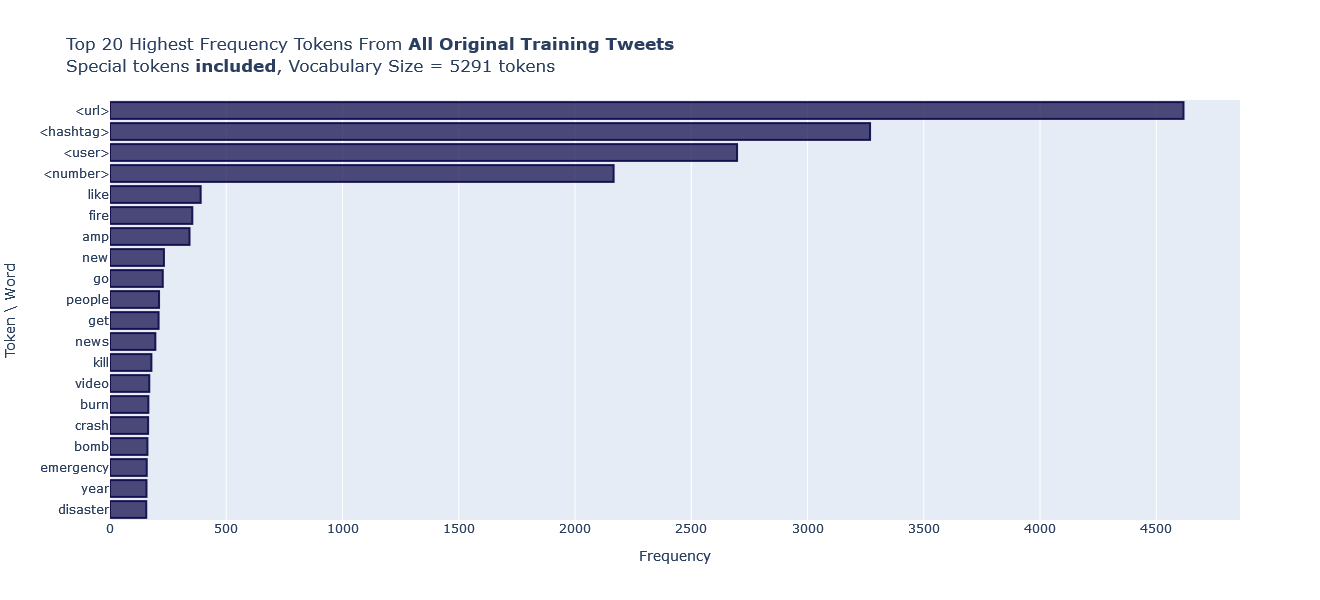

In [47]:
# all tokens
import plotly.graph_objects as go

df_sorted_top20 = df_token_counts_5291.iloc[0:20].copy()
df_sorted_top20.sort_values(['token_counts', 'token'], inplace=True, ascending=True)

fig_with_specials = go.Figure()
fig_with_specials.add_trace(go.Bar(
    y=df_sorted_top20['token'],
    x=df_sorted_top20['token_counts'],
    name='All',
    orientation='h',
    marker=dict(
        color='rgba(16, 11, 73, 0.73)',
        line=dict(color='rgba(16, 11, 73, 0.93)', width=2)
    )
))

fig_with_specials.update_layout(title='Top 20 Highest Frequency Tokens From <b>All Original Training Tweets</b><br>Special tokens <b>included</b>, Vocabulary Size = 5291 tokens',
                  xaxis_title='Frequency',
                  yaxis_title='Token \ Word',
                  autosize=False,
                  width=900,
                  height=600)

fig_with_specials.show()

In [48]:
# exluding special tokens
df_sorted_top20_no_specs = df_token_counts_5291.iloc[0:24].copy()
df_sorted_top20_no_specs.sort_values(['token_counts', 'token'], inplace=True, ascending=True)
df_sorted_top20_no_specs = df_sorted_top20_no_specs.iloc[0:20].copy()
df_sorted_top20_no_specs

token  token_counts
158        want           148
601        body           153
732      attack           155
57         come           155
40     disaster           156
175        year           157
52    emergency           158
1217       bomb           161
80        crash           164
167        burn           165
217       video           169
362        kill           178
111        news           195
24          get           209
20       people           211
68           go           227
123         new           232
228         amp           342
7          fire           354
98         like           390

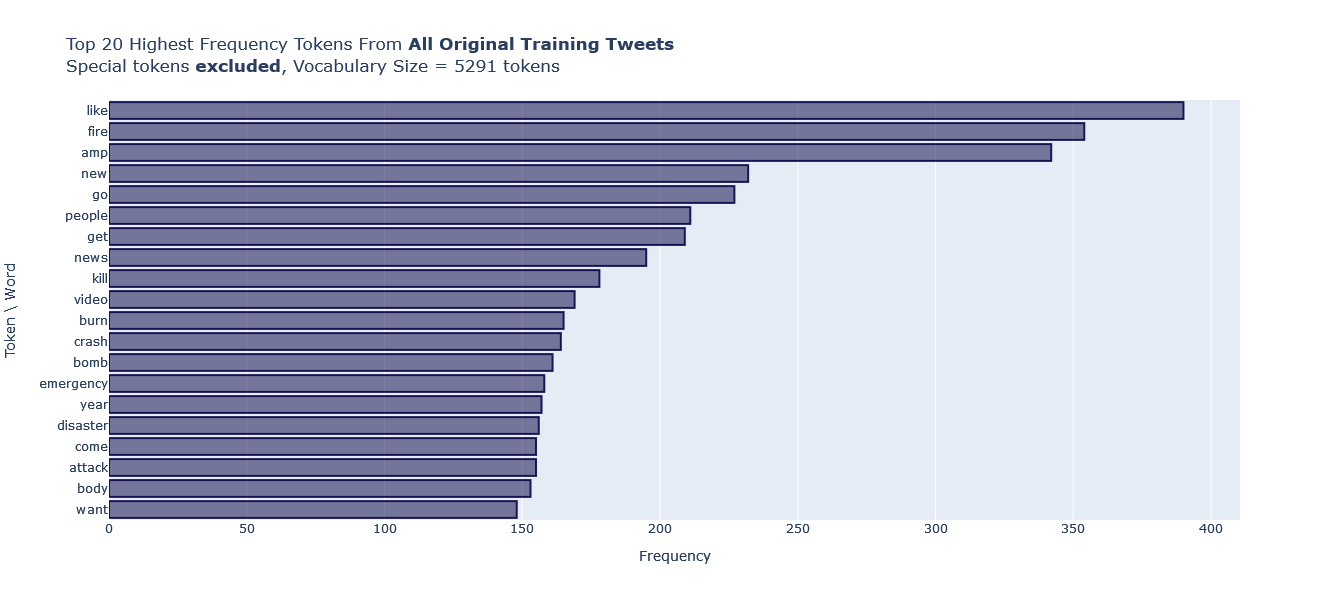

In [49]:
fig_no_specials = go.Figure()
fig_no_specials.add_trace(go.Bar(
    y=df_sorted_top20_no_specs['token'],
    x=df_sorted_top20_no_specs['token_counts'],
    name='No Special Tokens',
    orientation='h',
    marker=dict(
        color='rgba(16, 11, 73, 0.53)',
        line=dict(color='rgba(16, 11, 73, 0.93)', width=2)
    )
))

fig_no_specials.update_layout(title='Top 20 Highest Frequency Tokens From <b>All Original Training Tweets</b><br>Special tokens <b>excluded</b>, Vocabulary Size = 5291 tokens',
                  xaxis_title='Frequency',
                  yaxis_title='Token \ Word',
                  autosize=False,
                  width=900,
                  height=600)

fig_no_specials.show()

In [50]:
# get counts for each class in the training set
df_train_clean_v07_class0 = df_train_clean_v07.loc[df_train_clean_v07['target'] == 0, :]
df_train_clean_v07_class1 = df_train_clean_v07.loc[df_train_clean_v07['target'] == 1, :]

df_train_clean_v07_class0_counts = pt.count_tokens(df_train_clean_v07_class0['text'])
df_train_clean_v07_class1_counts = pt.count_tokens(df_train_clean_v07_class1['text'])

In [51]:
df_top20_c0 = df_train_clean_v07_class0_counts.head(20).sort_values(['token_counts', 'token'], ascending=True)
df_top20_c0

token  token_counts
267       think           100
52         time           100
213      people           101
115       video           101
11          day           102
180        come           105
73         know           106
1169        bag           109
1          love           118
350        body           119
66         want           125
140         get           154
174          go           161
40          new           175
128         amp           208
18         like           292
71     <number>           964
24    <hashtag>          1639
35       <user>          1819
27        <url>          2159

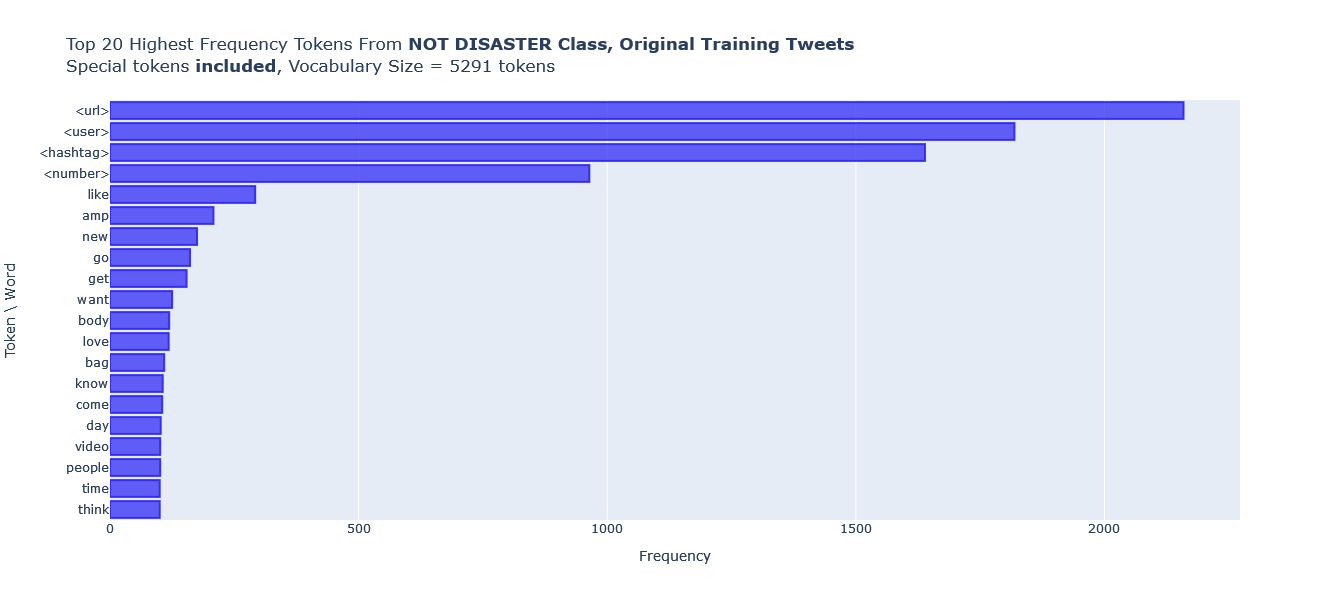

In [52]:
# class 0 with the special tokens
import plotly.graph_objects as go

fig_class0_with_specials = go.Figure()
fig_class0_with_specials.add_trace(go.Bar(
    y=df_top20_c0['token'],
    x=df_top20_c0['token_counts'],
    name='NOT Disaster',
    orientation='h',
    marker=dict(
        color='rgba(46, 39, 245, 0.73)',
        line=dict(color='rgba(46, 39, 245, 0.93)', width=2)
    )
))

fig_class0_with_specials.update_layout(title='Top 20 Highest Frequency Tokens From <b>NOT DISASTER Class, Original Training Tweets</b><br>Special tokens <b>included</b>, Vocabulary Size = 5291 tokens',
                  xaxis_title='Frequency',
                  yaxis_title='Token \ Word',
                  autosize=False,
                  width=900,
                  height=600)

fig_class0_with_specials.show()

In [53]:
df_top20_c1 = df_train_clean_v07_class1_counts.head(20).sort_values(['token_counts', 'token'], ascending=True)
df_top20_c1

token  token_counts
468       storm            96
463        like            98
271      family           102
114        home           102
443      attack           106
616     suicide           106
106      police           107
22       people           110
690        bomb           111
83        crash           113
25   california           114
43     disaster           116
335         amp           134
91         news           140
247        kill           159
6          fire           264
85       <user>           878
21     <number>          1202
1     <hashtag>          1630
89        <url>          2458

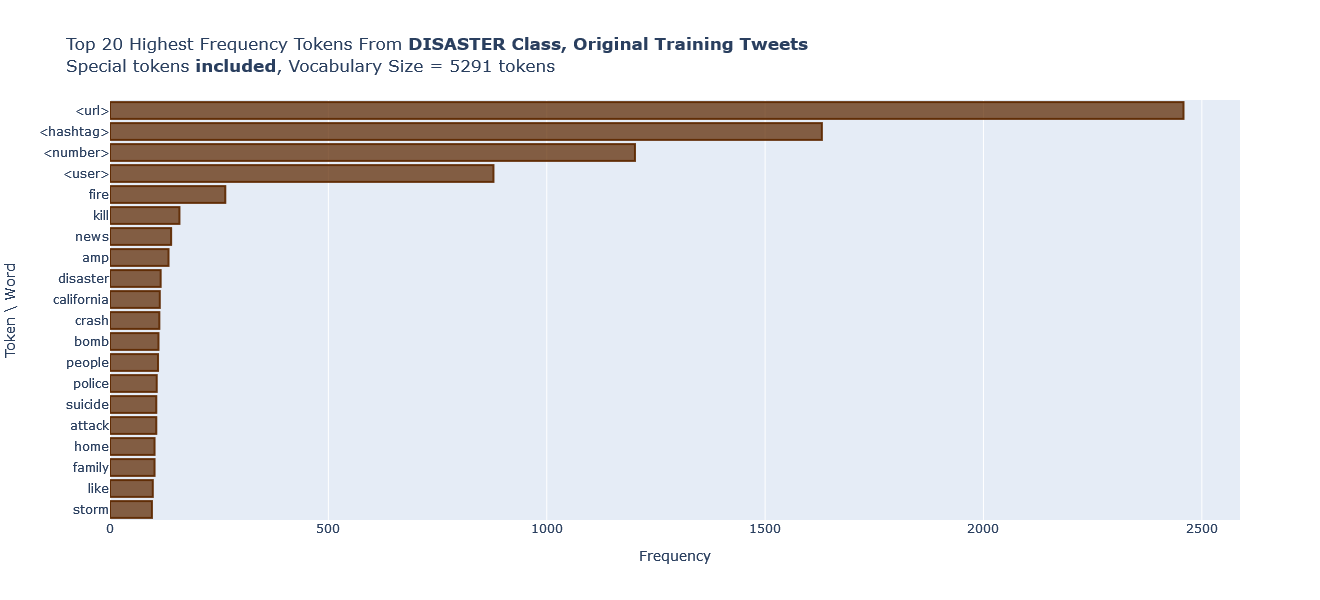

In [54]:
fig_class1_with_specials = go.Figure()
fig_class1_with_specials.add_trace(go.Bar(
    y=df_top20_c1['token'],
    x=df_top20_c1['token_counts'],
    name='NOT Disaster',
    orientation='h',
    marker=dict(
        color='rgba(93, 40, 0, 0.73)',
        line=dict(color='rgba(93, 40, 0, 0.93)', width=2)
    )
))

fig_class1_with_specials.update_layout(title='Top 20 Highest Frequency Tokens From <b>DISASTER Class, Original Training Tweets</b><br>Special tokens <b>included</b>, Vocabulary Size = 5291 tokens',
                  xaxis_title='Frequency',
                  yaxis_title='Token \ Word',
                  autosize=False,
                  width=900,
                  height=600)

fig_class1_with_specials.show()

In [55]:
df_top20_c0 = df_train_clean_v07_class0_counts.head(24).sort_values(['token_counts', 'token'], ascending=False)
df_top20_c0_no_specials = df_top20_c0.iloc[4:].sort_values(['token_counts', 'token'], ascending=True)
df_top20_c0_no_specials

token  token_counts
796     fire            90
32      look            90
243   scream            97
226     good           100
267    think           100
52      time           100
213   people           101
115    video           101
11       day           102
180     come           105
73      know           106
1169     bag           109
1       love           118
350     body           119
66      want           125
140      get           154
174       go           161
40       new           175
128      amp           208
18      like           292

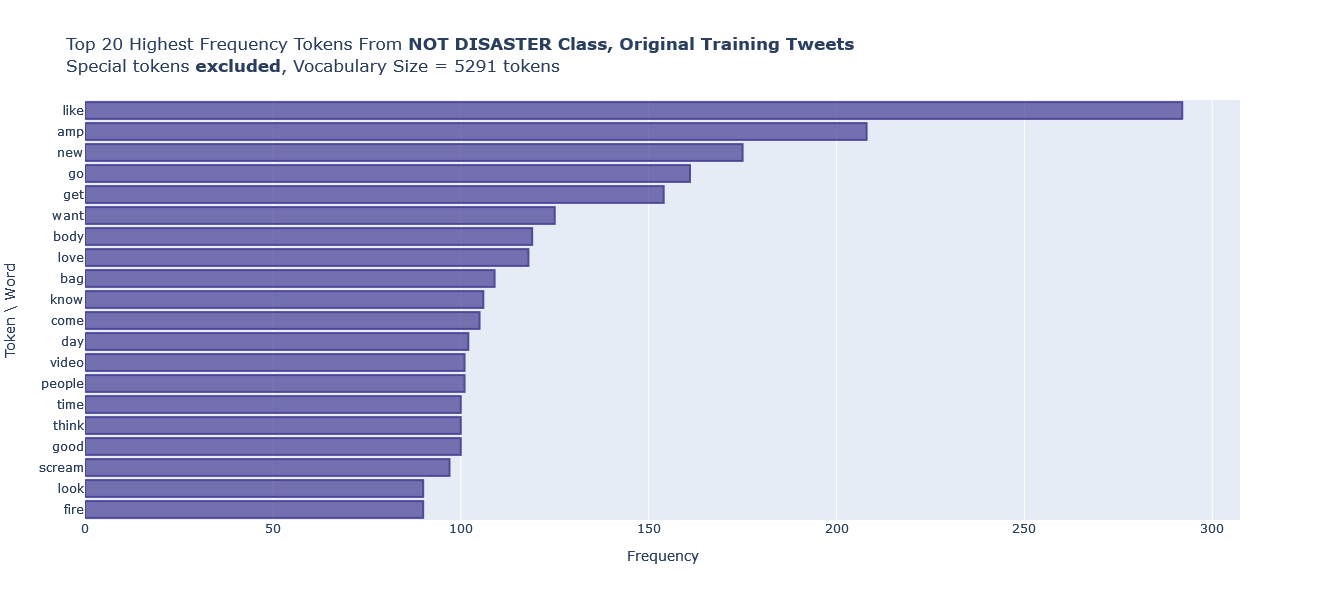

In [56]:
fig_class0_no_specials = go.Figure()
fig_class0_no_specials.add_trace(go.Bar(
    y=df_top20_c0_no_specials['token'],
    x=df_top20_c0_no_specials['token_counts'],
    name='NOT Disaster',
    orientation='h',
    marker=dict(
        color='rgba(73, 66, 149, 0.73)',
        line=dict(color='rgba(73, 66, 149, 0.93)', width=2)
    )
))

fig_class0_no_specials.update_layout(title='Top 20 Highest Frequency Tokens From <b>NOT DISASTER Class, Original Training Tweets</b><br>Special tokens <b>excluded</b>, Vocabulary Size = 5291 tokens',
                  xaxis_title='Frequency',
                  yaxis_title='Token \ Word',
                  autosize=False,
                  width=900,
                  height=600)

fig_class0_no_specials.show()

In [57]:
df_top20_c1 = df_train_clean_v07_class1_counts.head(24).sort_values(['token_counts', 'token'], ascending=False)
df_top20_c1_no_specials = df_top20_c1.iloc[4:].sort_values(['token_counts', 'token'], ascending=True)
df_top20_c1_no_specials

token  token_counts
42         flood            91
1012   hiroshima            91
116         year            92
370        train            93
468        storm            96
463         like            98
271       family           102
114         home           102
443       attack           106
616      suicide           106
106       police           107
22        people           110
690         bomb           111
83         crash           113
25    california           114
43      disaster           116
335          amp           134
91          news           140
247         kill           159
6           fire           264

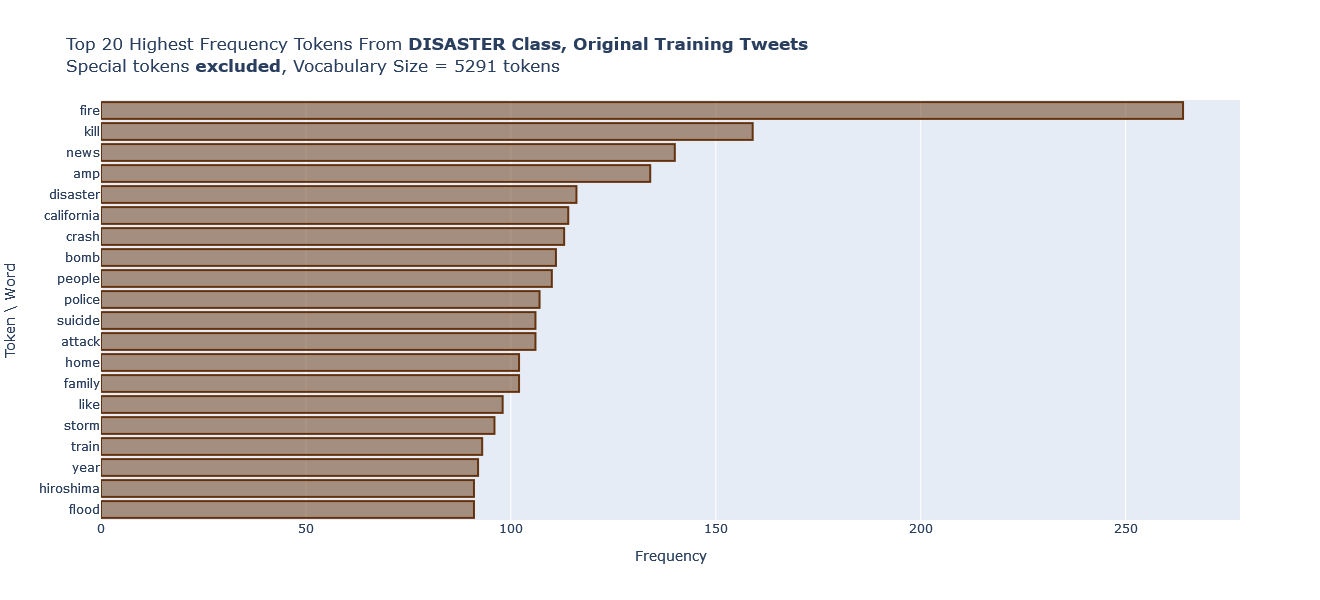

In [58]:
fig_class1_no_specials = go.Figure()
fig_class1_no_specials.add_trace(go.Bar(
    y=df_top20_c1_no_specials['token'],
    x=df_top20_c1_no_specials['token_counts'],
    name='NOT Disaster',
    orientation='h',
    marker=dict(
        color='rgba(93, 40, 0, 0.48)',
        line=dict(color='rgba(93, 40, 0, 0.93)', width=2)
    )
))

fig_class1_no_specials.update_layout(title='Top 20 Highest Frequency Tokens From <b>DISASTER Class, Original Training Tweets</b><br>Special tokens <b>excluded</b>, Vocabulary Size = 5291 tokens',
                  xaxis_title='Frequency',
                  yaxis_title='Token \ Word',
                  autosize=False,
                  width=900,
                  height=600)

fig_class1_no_specials.show()

In [59]:
# remove the special token counts from class 0
# df_train_clean_v07_class0_counts_no_specs = \
#     df_train_clean_v07_class0_counts.loc[~df_train_clean_v07_class0_counts['token'].isin(['<url>', '<user>', '<hashtag>', '<number>']), :]
# df_train_clean_v07_class0_counts_no_specs.head()

In [60]:
# remove the special token counts from class 1
# df_train_clean_v07_class1_counts_no_specs = \
#     df_train_clean_v07_class1_counts.loc[~df_train_clean_v07_class1_counts['token'].isin(['<url>', '<user>', '<hashtag>', '<number>']), :]
# df_train_clean_v07_class1_counts_no_specs.head()

In [61]:
# token counts per tweet
token_counts_per_tweet = data_mat.sum(axis=1)
print(token_counts_per_tweet.shape)

(7485,)


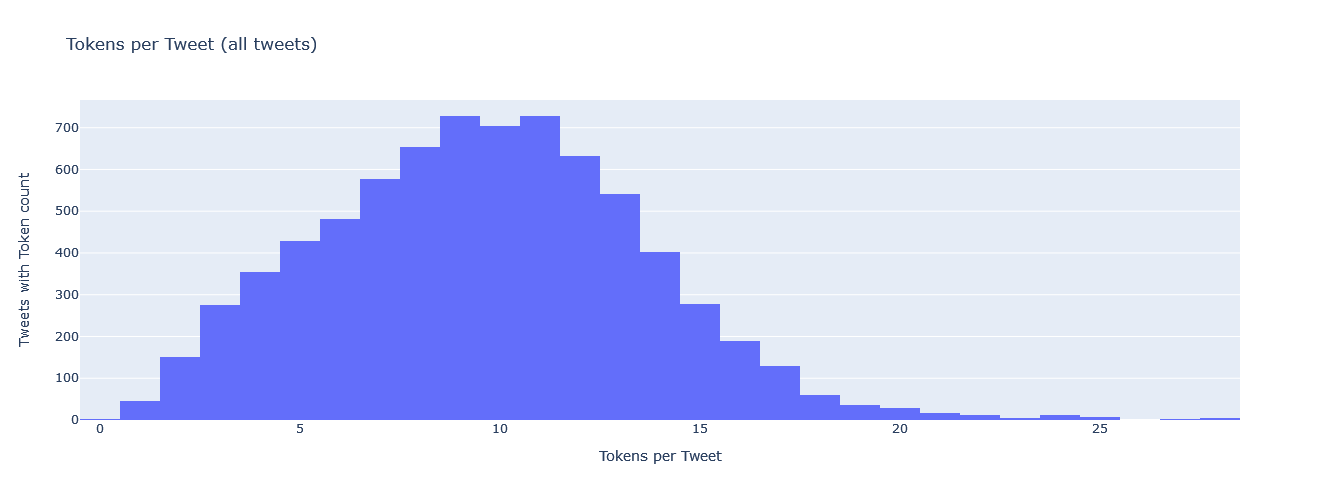

In [62]:
# first, look at overall distribution

fig_hist_tokens_all = go.Figure(data=[go.Histogram(x=token_counts_per_tweet)])
fig_hist_tokens_all.update_layout(title='Tokens per Tweet (all tweets)',
                       xaxis_title='Tokens per Tweet',
                       yaxis_title='Tweets with Token count',
                       legend=dict(yanchor="top",
                                   y=0.99,
                                   xanchor="left",
                                   x=0.01),
                       autosize=False,
                       width=900,
                       height=500)
fig_hist_tokens_all.show()

In [63]:
# break out class distributions

## add the special tokens to token_pattern parameter so we can preserve them
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,
                             token_pattern = r"(?u)\b\w\w+\b|<user>|<hashtag>|<url>|<number>",
                             preprocessor = None, max_features = vocabulary_size)
data_features_class0 = vectorizer.fit_transform(df_train_clean_v07_class0['text'])
data_features_class1 = vectorizer.fit_transform(df_train_clean_v07_class1['text'])
##
data_mat_class0 = data_features_class0.toarray()
data_mat_class1 = data_features_class1.toarray()

In [64]:
token_counts_per_tweet_class0 = data_mat_class0.sum(axis=1)
token_counts_per_tweet_class1 = data_mat_class1.sum(axis=1)
print(token_counts_per_tweet_class0.shape, token_counts_per_tweet_class1.shape)

(4297,) (3188,)


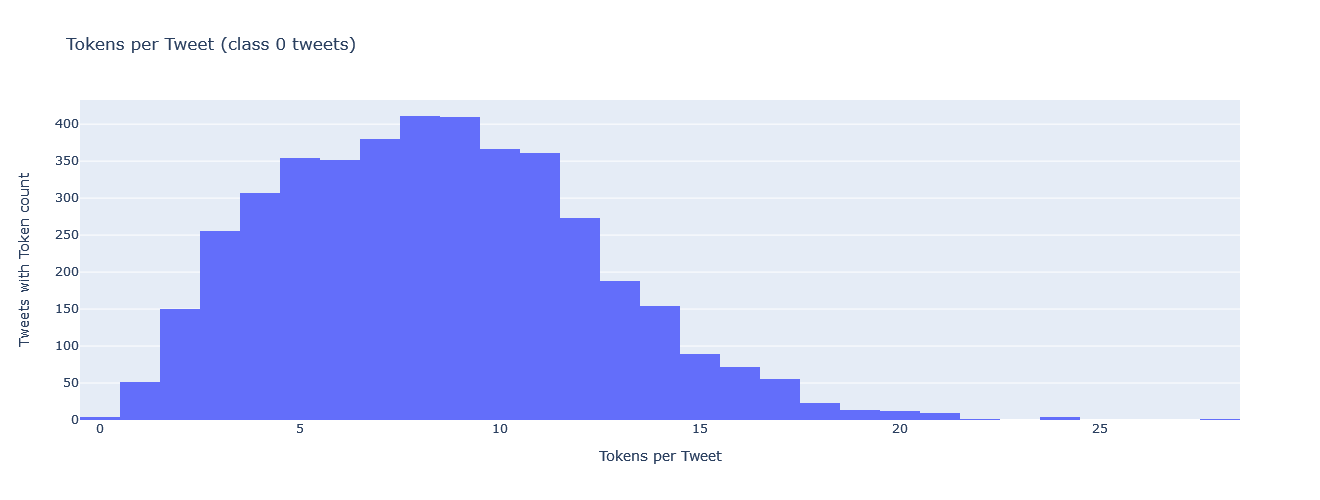

In [65]:
fig_hist_tokens_class0 = go.Figure(data=[go.Histogram(x=token_counts_per_tweet_class0)])
fig_hist_tokens_class0.update_layout(title='Tokens per Tweet (class 0 tweets)',
                       xaxis_title='Tokens per Tweet',
                       yaxis_title='Tweets with Token count',
                       legend=dict(yanchor="top",
                                   y=0.99,
                                   xanchor="left",
                                   x=0.01),
                       autosize=False,
                       width=900,
                       height=500)
fig_hist_tokens_class0.show()

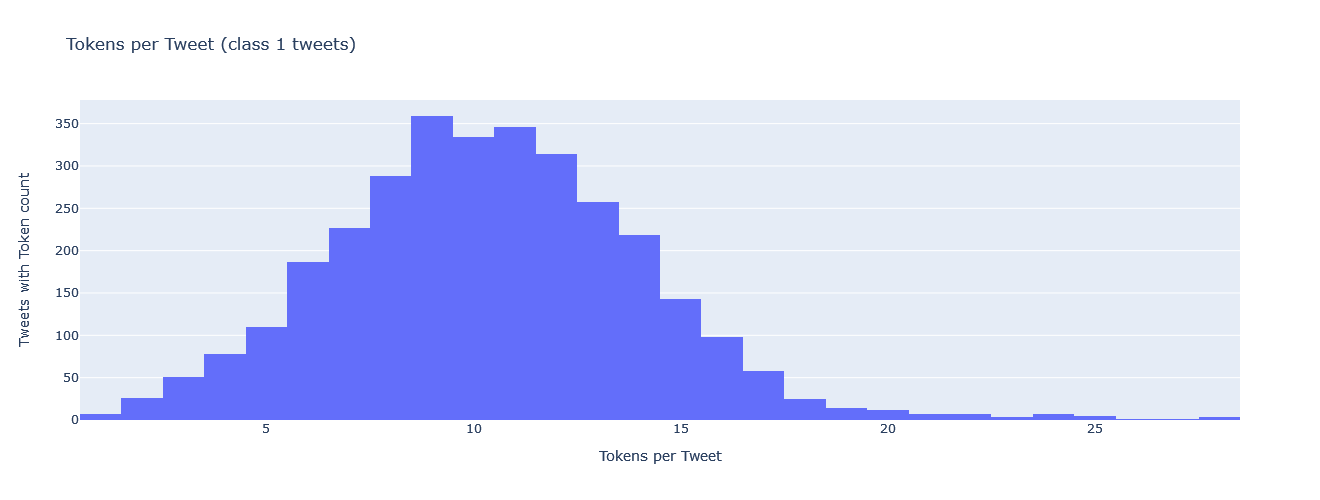

In [66]:
fig_hist_tokens_class1 = go.Figure(data=[go.Histogram(x=token_counts_per_tweet_class1)])
fig_hist_tokens_class1.update_layout(title='Tokens per Tweet (class 1 tweets)',
                       xaxis_title='Tokens per Tweet',
                       yaxis_title='Tweets with Token count',
                       legend=dict(yanchor="top",
                                   y=0.99,
                                   xanchor="left",
                                   x=0.01),
                       autosize=False,
                       width=900,
                       height=500)
fig_hist_tokens_class1.show()

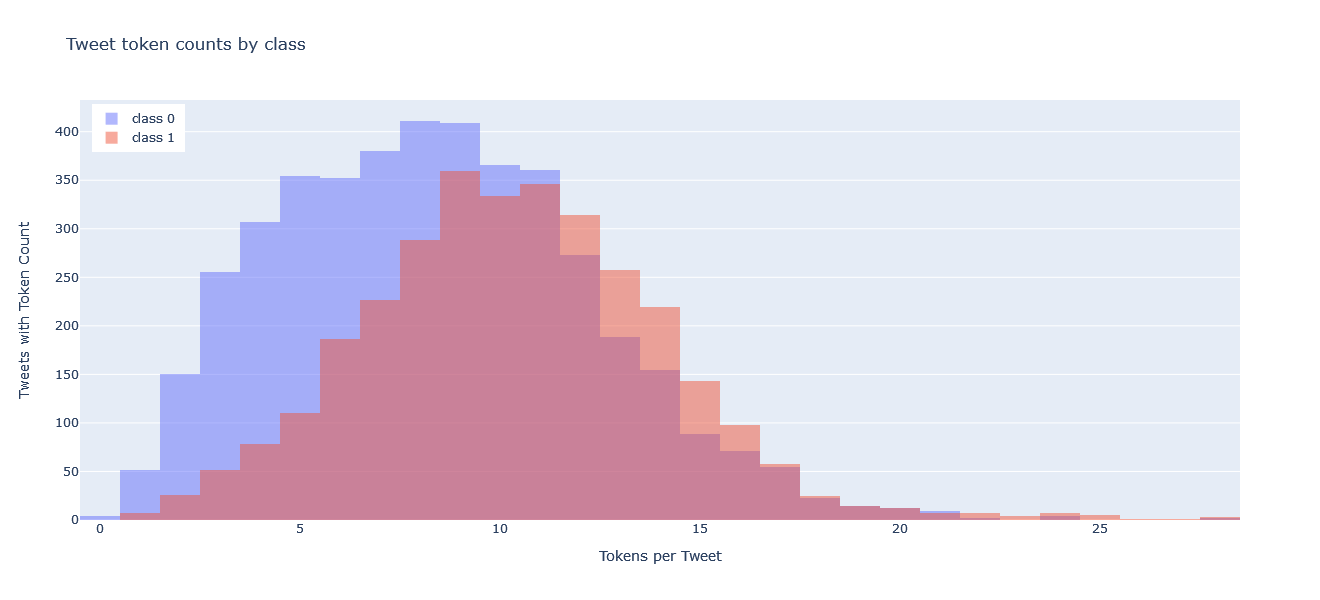

In [67]:
# create overlay of the 2 distributions
fig_overlay_hists = go.Figure()
fig_overlay_hists.add_trace(go.Histogram(x=token_counts_per_tweet_class0, name="class 0"))
fig_overlay_hists.add_trace(go.Histogram(x=token_counts_per_tweet_class1, name="class 1"))

# Overlay both histograms
fig_overlay_hists.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig_overlay_hists.update_traces(opacity=0.50)

fig_overlay_hists.update_layout(title='Tweet token counts by class',
                  xaxis_title='Tokens per Tweet',
                  yaxis_title='Tweets with Token Count',
                  legend=dict(yanchor="top",
                              y=0.99,
                              xanchor="left",
                              x=0.01),
                  autosize=False,
                  width=900,
                  height=600)

fig_overlay_hists.show()

## Class balance

In [68]:
# with open("./data/test_clean_v01.csv", encoding="utf8", errors='ignore') as f:
#     v01_test_lines = f.readlines()

total_train_samples = df_train_v03.shape[0]  # remaining training samples after both types of duplicates removed
total_test_samples = df_test_v01.shape[0]    # test set is what it is after spillover lines fixed
print(f"Training samples after dupes removed {total_train_samples}, Test samples after spillover fixes: {total_test_samples}")  # 7613 3263
print(df_train_v03.shape, df_test_v01.shape)

Training samples after dupes removed 7485, Test samples after spillover fixes: 3263
(7485, 5) (3263, 4)


In [69]:
class1_train_samples = df_train_v03['target'].sum()
class0_train_samples = total_train_samples - class1_train_samples
print(f"Class 0 training samples: {class0_train_samples}, Class 1 training samples: {class1_train_samples}")  # 4342 3271, a little class 0 heavy...
class0_portion = class0_train_samples / (class0_train_samples + class1_train_samples)
class1_portion = class1_train_samples / (class0_train_samples + class1_train_samples)
print(f"Class 0 data makes up {class0_portion} of the total data")
print(f"Class 1 data makes up {class1_portion} of the total data")

Class 0 training samples: 4297, Class 1 training samples: 3188
Class 0 data makes up 0.5740814963259853 of the total data
Class 1 data makes up 0.4259185036740147 of the total data


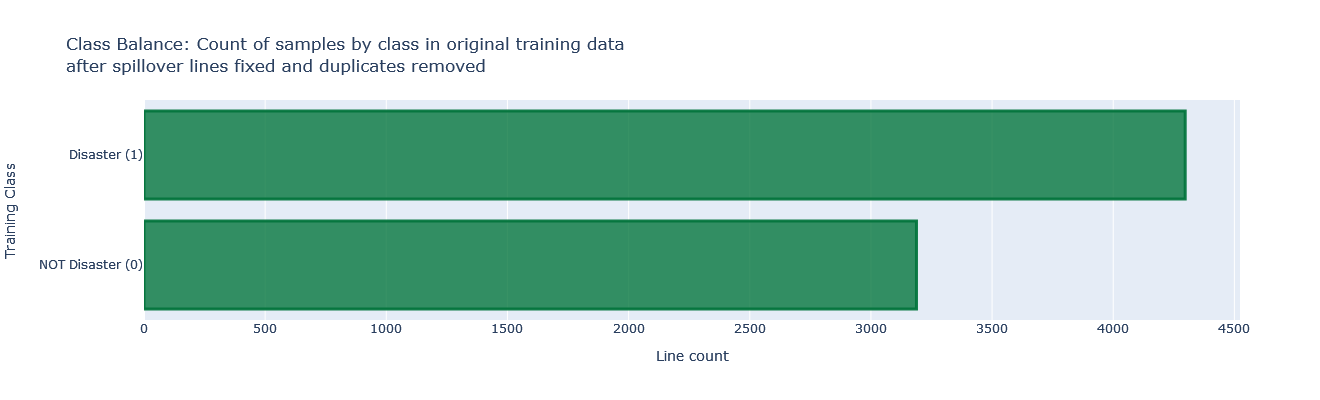

In [75]:
fig_class_balance = go.Figure()
fig_class_balance.add_trace(
    go.Bar(
        y = ['NOT Disaster (0)', 'Disaster (1)'],
        x = [class1_train_samples, class0_train_samples],
        name = 'Training data',
        orientation = 'h',
        marker=dict(
            color='rgba(2, 116, 60, 0.79)',
            line=dict(color='rgba(2, 116, 60, 0.93)', width=3)
        )
    )
)
fig_class_balance.update_layout(title='Class Balance: Count of samples by class in original training data<br>after spillover lines fixed and duplicates removed',
                                # title='Class balance: Portion of samples by class',
                                xaxis_title='Line count',
                                yaxis_title='Training Class',
                                legend=dict(yanchor="top",
                                            y=0.99,
                                            xanchor="left",
                                            x=0.80),
                                 autosize=False,
                                 width=900,
                                 height=400)

fig_class_balance.show()

## Tweet length by class

Tweets that are disaster-response related tend to be longer on average than those that aren't.

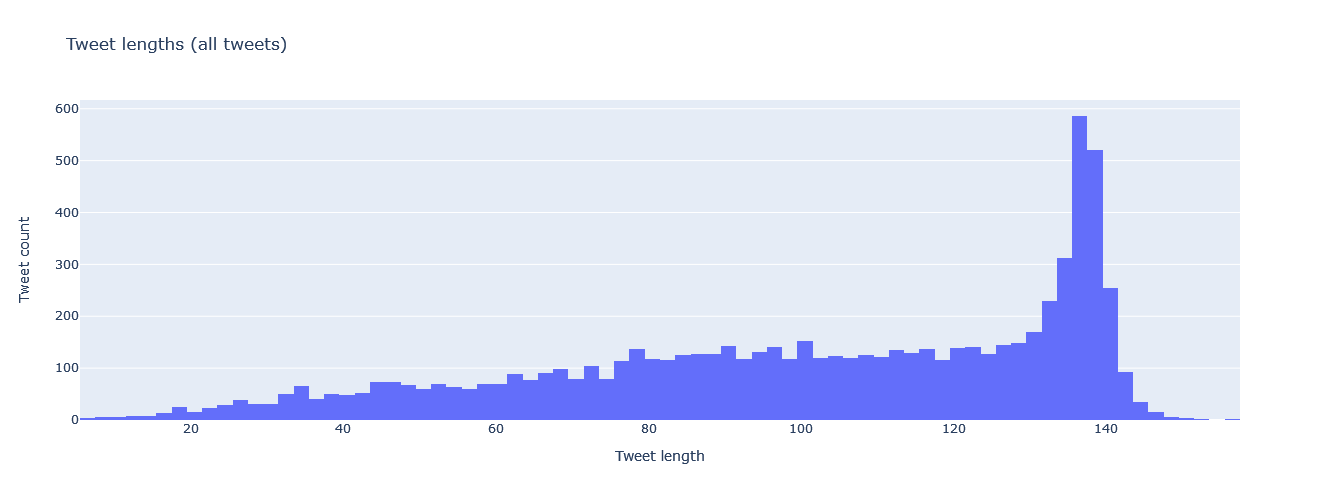

In [76]:
import pandas as pd
import spacy as sp

# break out the text column from line consolidated data so it can be operated on separately
df_train03 = pd.read_csv('./data/train_clean_v03.csv', encoding="utf8")
# df_test01 = pd.read_csv('./data/test_clean_v01.csv', encoding="utf8")

# first, look at overall distribution
train_tweet_lens = []
train_text_lines = df_train03['text'].to_list()
for text in train_text_lines:
    train_tweet_lens.append(len(text))

train_tweet_lens = np.array(train_tweet_lens)
fig_hist = go.Figure(data=[go.Histogram(x=train_tweet_lens)])
fig_hist.update_layout(title='Tweet lengths (all tweets)',
                       xaxis_title='Tweet length',
                       yaxis_title='Tweet count',
                       legend=dict(yanchor="top",
                                   y=0.99,
                                   xanchor="left",
                                   x=0.01),
                       autosize=False,
                       width=900,
                       height=500)
fig_hist.show()

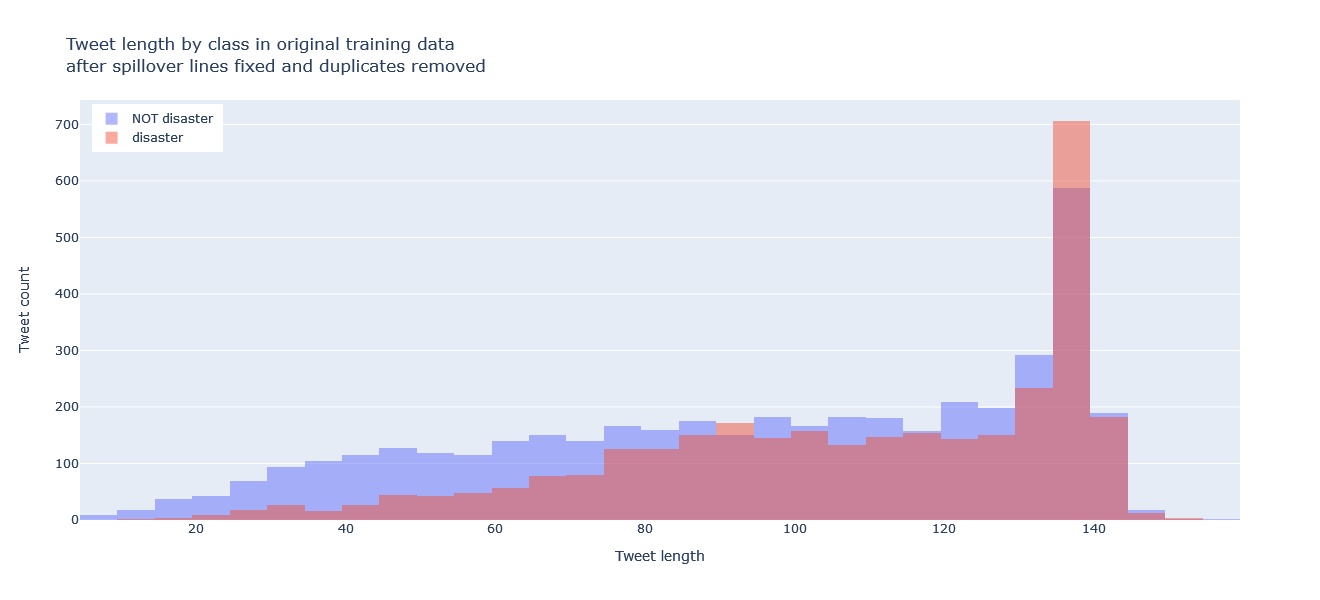

In [77]:
# print(df_train01.columns)  # ['id', 'keyword', 'location', 'text', 'target']
# separate the classes
train_class0_lens = df_train03.loc[df_train03['target'] == 0, ['text', 'target']]  # not disaster
train_class1_lens = df_train03.loc[df_train03['target'] == 1, ['text', 'target']]  # disaster
# compute the tweet lengths
train_class0_lens['text_len'] = train_class0_lens.apply(lambda row: len(row['text']), axis=1)
train_class1_lens['text_len'] = train_class1_lens.apply(lambda row: len(row['text']), axis=1)

# create overlay of the 2 distributions
fig_overlay_hists = go.Figure()
fig_overlay_hists.add_trace(go.Histogram(x=train_class0_lens['text_len'], name="NOT disaster"))
fig_overlay_hists.add_trace(go.Histogram(x=train_class1_lens['text_len'], name="disaster"))

# Overlay both histograms
fig_overlay_hists.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig_overlay_hists.update_traces(opacity=0.50)

fig_overlay_hists.update_layout(title='Tweet length by class in original training data<br>after spillover lines fixed and duplicates removed',
                  xaxis_title='Tweet length',
                  yaxis_title='Tweet count',
                  legend=dict(yanchor="top",
                              y=0.99,
                              xanchor="left",
                              x=0.01),
                  autosize=False,
                  width=900,
                  height=600)

fig_overlay_hists.show()

In [78]:
# How many tweets are missing (0 length)?
train_class0_lens.sort_values(['text_len']).head()

text  target  text_len
1858   Crushed       0         7
5018   Err:509       0         7
4794   Bad day       0         7
30    The end!       0         8
24    LOOOOOOL       0         8

In [79]:
# as a double check...
print(train_class0_lens['text_len'].min(), train_class1_lens['text_len'].min())  # all tweets >=7 chars class 0, >=14 chars class 1
print(train_class0_lens.shape[0], train_class1_lens.shape[0])

7 14
4297 3188


In [80]:
# any missing keyword and location values
train_class0_lens = df_train03.loc[df_train03['target'] == 0, ['keyword', 'location', 'text', 'target']]  # not disaster
train_class1_lens = df_train03.loc[df_train03['target'] == 1, ['keyword', 'location', 'text', 'target']]  # disaster

# https://stackoverflow.com/questions/40950310/strip-trim-all-strings-of-a-dataframe
# print(type(train_class0_lens['keyword'].dtype), type(train_class0_lens['keyword'].dtype))  # strings: <class 'numpy.dtypes.ObjectDType'>
train_class0_lens['keyword'] = train_class0_lens['keyword'].str.strip()
train_class1_lens['keyword'] = train_class1_lens['keyword'].str.strip()

# how many missing or empty locations, compute location lengths
train_class0_lens['keyw_len'] = train_class0_lens['keyword'].str.len().fillna(0)
train_class1_lens['keyw_len'] = train_class1_lens['keyword'].str.len().fillna(0)
train_zero_len_class0 = train_class0_lens.loc[train_class0_lens['keyw_len'] == 0, :]
train_zero_len_class1 = train_class1_lens.loc[train_class1_lens['keyw_len'] == 0, :]

# train_class0_lens.sort_values(['keyw_len'])

print(train_zero_len_class0.shape[0], train_zero_len_class1.shape[0])  # small number, but not using location so we don't really care...

19 37
